In [114]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from pandas import concat
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [115]:
train_ratio = 0.75
batch_size = 40
epochs = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [116]:
# import raw data and plot
data_set = pd.read_csv('Wordle.csv')
words = data_set["Word"].values

In [117]:
words_one_hot = []
for word in words:
    word_vec = []
    for letter in word:
        letter_one_hot = np.zeros(26)
        letter_one_hot[ord(letter) - 97] = 1
        word_vec.append(letter_one_hot)
    word_vec = np.array(word_vec)
    words_one_hot.append(word_vec.reshape(-1))
words_one_hot = np.array(words_one_hot)
np.shape(words_one_hot)

(357, 130)

In [118]:
distribution = data_set[["1 try", "2 tries", "3 tries", "4 tries", "5 tries", "6 tries", "7 or more tries (X)"]].values
scaler = MinMaxScaler(feature_range=(0, 1))
distribution = scaler.fit_transform(distribution)
np.shape(distribution)

(357, 7)

In [119]:
class WordDistributionDataset(Dataset):
    def __init__(self, data_features, data_target):
        self.len = len(data_features)
        self.features = torch.tensor(data_features, dtype=torch.float32, device=device)
        self.target = torch.tensor(data_target, dtype=torch.float32, device=device)

    def __getitem__(self, index):
        return self.features[index], self.target[index]

    def __len__(self):
        return self.len

In [120]:
train_size = int(len(words_one_hot) * train_ratio)
train_words_np = words_one_hot[:train_size, ]
train_distribution_np = distribution[:train_size, ]
test_words_np = words_one_hot[train_size:, ]
test_distribution_np = distribution[train_size:, ]
print('train_x.shape, train_y.shape, test_x.shape, test_y.shape')
print(train_words_np.shape, train_distribution_np.shape, test_words_np.shape, test_distribution_np.shape)

train_x.shape, train_y.shape, test_x.shape, test_y.shape
(267, 130) (267, 7) (90, 130) (90, 7)


In [121]:
train_set = WordDistributionDataset(data_features=train_words_np, data_target=train_distribution_np)
test_set = WordDistributionDataset(data_features=test_words_np, data_target=test_distribution_np)
train_set_iter = DataLoader(dataset=train_set,
                            batch_size=batch_size,
                            shuffle=True)
test_set_iter = DataLoader(dataset=test_set,
                           batch_size=batch_size,
                           shuffle=)

In [122]:
class Net(nn.Module):
    def __init__(self, features):
        super(Net, self).__init__()

        self.linear_relu1 = nn.Linear(features, 128)
        self.linear_relu2 = nn.Linear(128, 256)
        self.linear_relu3 = nn.Linear(256, 256)
        self.linear_relu4 = nn.Linear(256, 256)
        self.linear5 = nn.Linear(256, 7)

    def forward(self, x):
        y_pred = self.linear_relu1(x)
        y_pred = nn.functional.relu(y_pred)

        y_pred = self.linear_relu2(y_pred)
        y_pred = nn.functional.relu(y_pred)

        y_pred = self.linear_relu3(y_pred)
        y_pred = nn.functional.relu(y_pred)

        y_pred = self.linear_relu4(y_pred)
        y_pred = nn.functional.relu(y_pred)

        y_pred = self.linear5(y_pred)
        return y_pred

In [125]:
model = Net(features=train_words_np.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [129]:
model.train()
for e in range(epochs):
    for i, (word_vec, distribution_vec) in enumerate(train_set_iter):
        out = model(word_vec)
        loss = criterion(out, distribution_vec)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (e + 1) % 20 == 0:
        print(f'epoch: {e + 1}, loss: {loss.data}')
torch.save(model.state_dict(), 'myModel.pth')

epoch: 20, loss: 0.0003407542244531214
epoch: 40, loss: 7.611345063196495e-05
epoch: 60, loss: 2.6892268579103984e-05
epoch: 80, loss: 4.826884378417162e-06
epoch: 100, loss: 4.904808292849339e-07
epoch: 120, loss: 3.954688736484968e-07
epoch: 140, loss: 1.1529610674188007e-05
epoch: 160, loss: 7.42487027309835e-05
epoch: 180, loss: 0.0001268464111490175
epoch: 200, loss: 2.933480755018536e-05
epoch: 220, loss: 2.99491330224555e-06
epoch: 240, loss: 6.913126071594888e-06
epoch: 260, loss: 2.076556302199606e-05
epoch: 280, loss: 0.00015874140080995858
epoch: 300, loss: 0.00013502412184607238
epoch: 320, loss: 6.113974814070389e-05
epoch: 340, loss: 4.153655936534051e-06
epoch: 360, loss: 7.325812134695298e-07
epoch: 380, loss: 2.056671291938983e-06
epoch: 400, loss: 1.3672226486960426e-05
epoch: 420, loss: 0.0001979052904061973
epoch: 440, loss: 0.00013088356354273856
epoch: 460, loss: 5.606321428786032e-05
epoch: 480, loss: 5.989053079247242e-06
epoch: 500, loss: 5.94593029745738e-06


In [134]:
model.load_state_dict(torch.load("myModel.pth"))
model.eval()
out = model(torch.tensor(test_words_np, dtype=torch.float32, device=device))
pred_y = out.cpu().data.numpy()
pred_y = scaler.inverse_transform(pred_y)
pred_y

array([[ 1.15657353e+00,  9.83638573e+00,  2.32048206e+01,
         2.46671009e+01,  1.95243816e+01,  1.54710903e+01,
         5.48651123e+00],
       [ 8.40906858e-01,  1.07042694e+01,  2.66982555e+01,
         2.65863037e+01,  1.91452484e+01,  1.15474997e+01,
         4.41072083e+00],
       [ 2.02776104e-01,  3.69435668e+00,  1.80380287e+01,
         3.29883881e+01,  2.65602112e+01,  1.45074463e+01,
         3.50377703e+00],
       [ 2.98120320e-01,  4.87143469e+00,  1.72959404e+01,
         2.96817417e+01,  2.73782196e+01,  1.71444721e+01,
         3.67724156e+00],
       [ 1.30160809e-01,  4.05163145e+00,  2.32053680e+01,
         3.58809357e+01,  2.44259720e+01,  1.08190489e+01,
         1.28749979e+00],
       [ 6.63017482e-02,  3.15907478e+00,  1.68909550e+01,
         3.32288628e+01,  2.94124126e+01,  1.38093576e+01,
         2.25268340e+00],
       [-6.51882216e-02,  4.59489775e+00,  2.46339874e+01,
         3.51245651e+01,  2.30504055e+01,  1.03646564e+01,
         2.0145151

In [140]:
word_pred = "eerie"
word_pred_vec = []
for letter in word_pred:
    letter_one_hot = np.zeros(26)
    letter_one_hot[ord(letter) - 97] = 1
    word_pred_vec.append(letter_one_hot)
word_pred_vec = np.array(word_pred_vec)
word_pred_vec = word_pred_vec.reshape(-1)
pred_eerie = model(torch.tensor(word_pred_vec, dtype=torch.float32, device=device))
pred_eerie = pred_eerie.cpu().data.numpy().reshape(1, -1)
pred_eerie = scaler.inverse_transform(pred_eerie)
pred_eerie

array([[ 0.33044922,  5.7433715 , 21.434603  , 32.10531   , 25.818512  ,
        12.460237  ,  1.7399274 ]], dtype=float32)

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  """


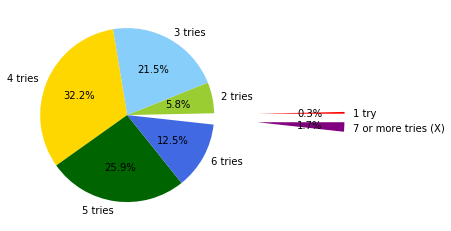

In [147]:
pred_eerie[pred_eerie < 0] = 0
label = ["1 try", "2 tries", "3 tries", "4 tries", "5 tries", "6 tries", "7 or more tries (X)"]
expld = [1.5, 0, 0, 0, 0, 0, 1.5]
colors = ['red','yellowgreen','lightskyblue', "gold", "darkgreen", "royalblue", "purple"]
plt.pie(pred_eerie, explode=expld, labels=label, autopct='%3.1f%%', colors=colors)
plt.show()